In [ ]:
from dotenv import load_dotenv
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from sqlalchemy import create_engine
from os import environ as env

In [2]:
load_dotenv()
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [ ]:
conn = psycopg2.connect(
    host=db_host,
    database=db_name,
    user=db_user,
    password=db_password
)

In [4]:
heart_metrics = {
    'Happiness': 'Measure of user satisfaction and happiness with the Questions & Answers product.',
    'Engagement': 'Measure of user interaction and activity on the platform.',
    'Adoption': 'Measure of user acquisition and growth of Stack Overflow user base.',
    'Retention': 'Measure of user retention and continued usage of the platform over time.',
    'Task Success': 'Measure of user ability to accomplish their goals and tasks effectively on Stack Overflow.'
}

In [5]:
# With the env variables loaded we can insert them into the engine connection string.
engine = create_engine(f"postgresql+psycopg2://{env['DB_USER']}:{env['DB_PASSWORD']}@{env['DB_HOST']}/{env['DB_NAME']}")
connection = engine.connect()

# Goal
## See how number of posts changed on a daily rate

I want to see how the number of posts have changed on a daily rate, to see if our users are getting more engaged with each others content.\
To start, I need to gather the creation dates of posts.

In [6]:
query = 'SELECT creation_date::date FROM posts LIMIT 50000'
df = pd.read_sql(query, connection)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   creation_date  50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [8]:
df.describe()

,creation_date
count,50000
unique,49
top,2008-09-16
freq,6534


In [9]:
df

,creation_date
0,2008-07-31
1,2008-07-31
2,2008-07-31
3,2008-07-31
4,2008-07-31
...,...
49995,2008-09-17
49996,2008-09-17
49997,2008-09-17
49998,2008-09-17


I now have the first 50,000 posts and the date each were made. Currently they seem like they are in date order.\
I would like to reduce the number of rows so that I have a row for each date and the quantity of posts on that date.


In [10]:
query = 'SELECT creation_date::date, COUNT(*) FROM posts GROUP BY creation_date::date'
posts_df = pd.read_sql(query, connection)

In [11]:
posts_df['creation_date'] = pd.to_datetime(posts_df['creation_date'])
posts_df.sort_values('creation_date')

,creation_date,count
5023,2008-07-31,6
4226,2008-08-01,137
4710,2008-08-02,93
3413,2008-08-03,130
4634,2008-08-04,315
...,...,...
3951,2022-11-30,12123
4299,2022-12-01,12310
811,2022-12-02,11750
4723,2022-12-03,7934


I have got each day now with a count on how many posts were made on that date.\
I will now plot a graph to see how it has changed over time.


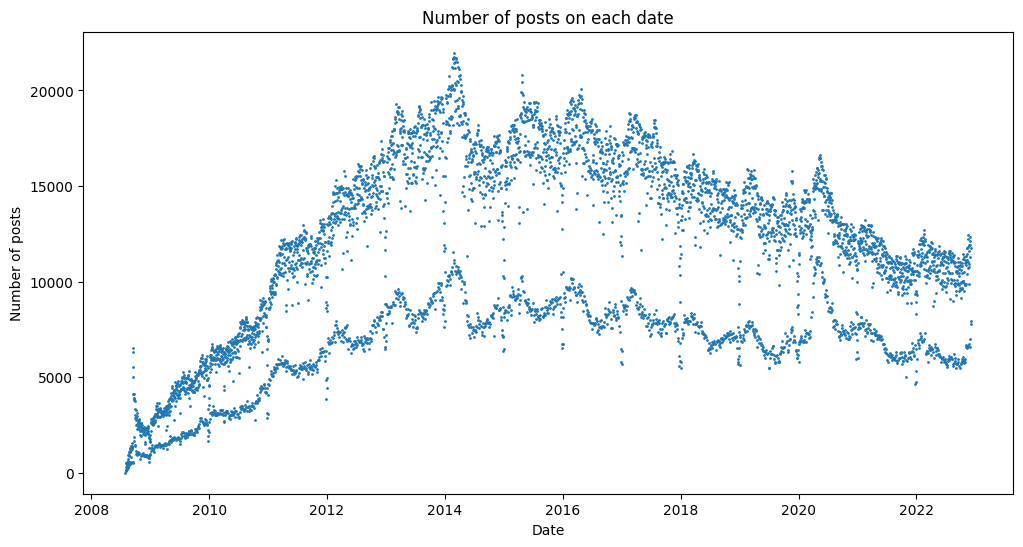

In [12]:
x = posts_df['creation_date']
y = posts_df['count']


plt.figure(figsize=(12, 6))
plt.scatter(x,y, s=1)
plt.title('Number of posts on each date')
plt.xlabel('Date')
plt.ylabel('Number of posts')
plt.show()

There is a large increase up until 2014 and has been steadily in decline since.\
There is a strange gap in the middle. I suspect that it is due to more posts happening on weekdays, than on weekends.\
I'm going to stretch out a new scatter plot over the period of a year, then also a month to see if the divide accounts for working days and weekends.

In [13]:
filtered_df = posts_df.loc[(posts_df['creation_date'] >= '2014-01-01') & (posts_df['creation_date'] <= '2014-12-31')]

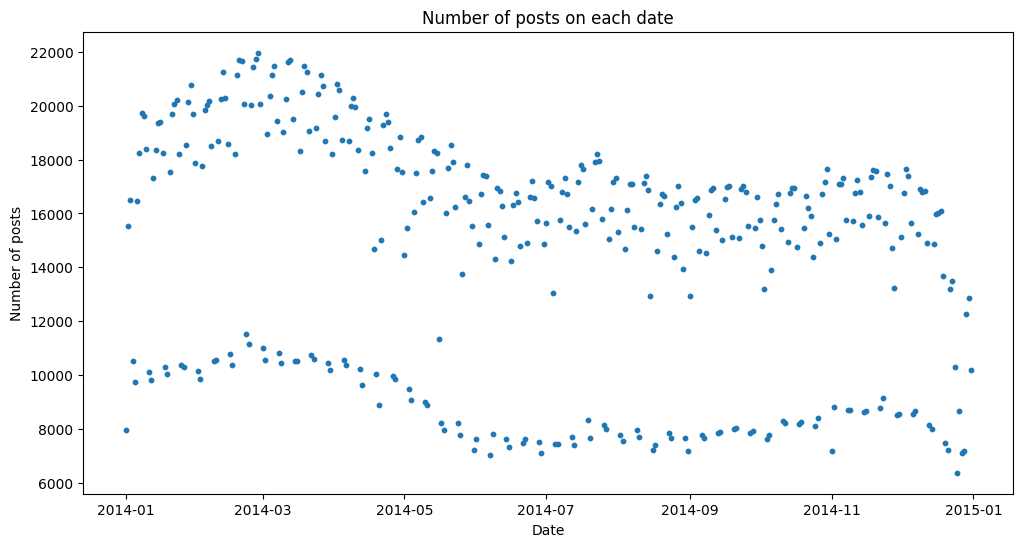

In [14]:
x = filtered_df['creation_date']
y = filtered_df['count']


plt.figure(figsize=(12, 6))
plt.scatter(x,y, s=10)
plt.title('Number of posts on each date')
plt.xlabel('Date')
plt.ylabel('Number of posts')
plt.show()

In [15]:
march_df = posts_df.loc[(posts_df['creation_date'] >= '2014-03-01') & (posts_df['creation_date'] < '2014-04-01')]

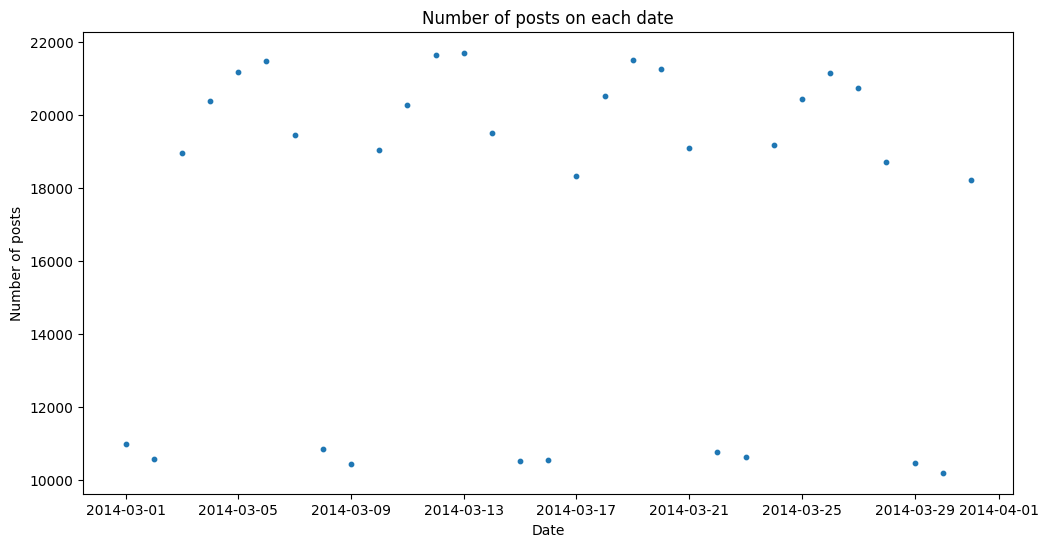

In [16]:
x = march_df['creation_date']
y = march_df['count']


plt.figure(figsize=(12, 6))
plt.scatter(x,y, s=10)
plt.title('Number of posts on each date')
plt.xlabel('Date')
plt.ylabel('Number of posts')
plt.show()

Looking at the grouped pairs at the bottom of the graph and groups of five along the top, the split is down to the working days.\
I would now like to look at the posts and comments for each day on the same graph.


In [17]:
query = 'SELECT creation_date::date, COUNT(*) FROM comments GROUP BY creation_date::date'
comments_df = pd.read_sql(query, connection)

In [18]:
comments_df['creation_date'] = pd.to_datetime(comments_df['creation_date'])

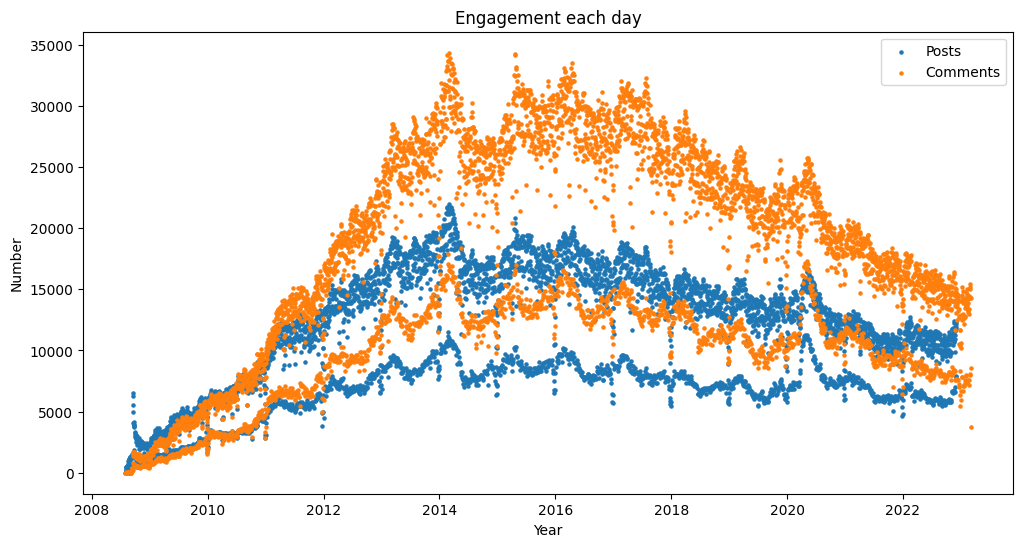

In [19]:
posts_x = posts_df['creation_date']
posts_y = posts_df['count']

comments_x = comments_df['creation_date']
comments_y = comments_df['count']


plt.figure(figsize=(12, 6))
plt.scatter(posts_x,posts_y, s=5, label='Posts')
plt.scatter(comments_x, comments_y, s=5, label='Comments')
plt.title('Engagement each day')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend(loc="upper right")
plt.show()

This was probably as expected. There are around twice as many comments as there are posts, because each post can have multiple comments.\
I am now going to try and average them on a per month basis, because maybe this many dots doesn't prove that useful.


In [20]:
posts_monthly = posts_df.groupby(pd.Grouper(key='creation_date', freq='M')).mean().astype(int)
posts_monthly['creation_date'] = posts_monthly.index

In [21]:
comments_monthly = comments_df.groupby(pd.Grouper(key='creation_date', freq='M')).mean().astype(int)
comments_monthly['creation_date'] = comments_monthly.index

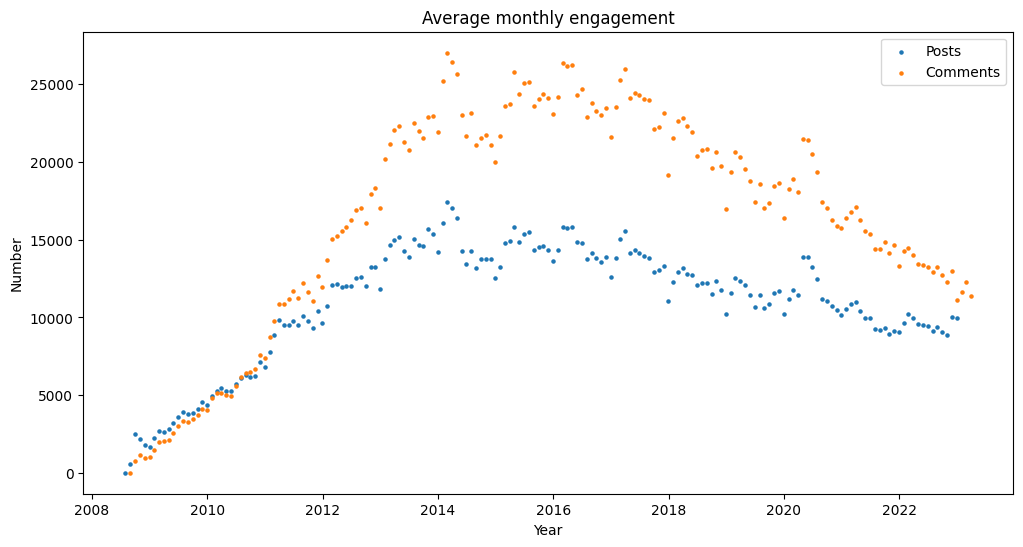

In [22]:
posts_monthly_x = posts_monthly['creation_date']
posts_monthly_y = posts_monthly['count']

comments_monthly_x = comments_monthly['creation_date']
comments_monthly_y = comments_monthly['count']

plt.figure(figsize=(12, 6))
plt.scatter(posts_monthly_x,posts_monthly_y, s=5, label='Posts')
plt.scatter(comments_monthly_x, comments_monthly_y, s=5, label='Comments')
plt.title('Average monthly engagement')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend(loc="upper right")
plt.show()

Here I have now broken down the graph to be monthly averages of posts and comments.\
After look through the posts data, I now realise I've made a mistake.\
Comments are not answers to posts.

# Goal
## I would like to look into the posts that are created, the number of answers on them and whether the post has an accepted answer.
To start, I will take a look at how many posts go unanswered entirely, and then make a comparison between the number of posts each day.


In [23]:
query = "SELECT answer_count, COUNT(*) FROM posts GROUP BY answer_count"
df = pd.read_sql(query, connection)

In [24]:
df

,answer_count,count
0,0.0,3367908
1,1.0,11878002
2,2.0,4862399
3,3.0,1800075
4,4.0,707692
...,...,...
118,296.0,1
119,320.0,1
120,407.0,1
121,518.0,1


Interestingly, there is a lot of 0 counts, but also NaN options. This makes me think there is a difference there in the data.\
I took a look at one of the posts with a NaN in the answer_count, and it is a reply to a question. A post can be both an original post, but also an answer to a post in it's own right.\
There is a post_type_id column, with type 1 being an original question, and type 2 being an answer.\
I need to redo the query above but only if the post_type_id = 1.

In [25]:
query = "SELECT answer_count, COUNT(*) FROM posts WHERE post_type_id = 1 GROUP BY answer_count"
df = pd.read_sql(query, connection)

In [26]:
df

,answer_count,count
0,0,3367908
1,1,11878002
2,2,4862399
3,3,1800075
4,4,707692
...,...,...
117,214,1
118,296,1
119,320,1
120,407,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   answer_count  122 non-null    int64
 1   count         122 non-null    int64
dtypes: int64(2)
memory usage: 2.0 KB


In [28]:
df.describe()

,answer_count,count
count,122.000000,1.220000e+02
mean,74.631148,1.907624e+05
std,74.136484,1.204311e+06
min,0.000000,1.000000e+00
25%,30.250000,2.000000e+00
50%,60.500000,9.500000e+00
75%,91.750000,3.532500e+02
max,518.000000,1.187800e+07


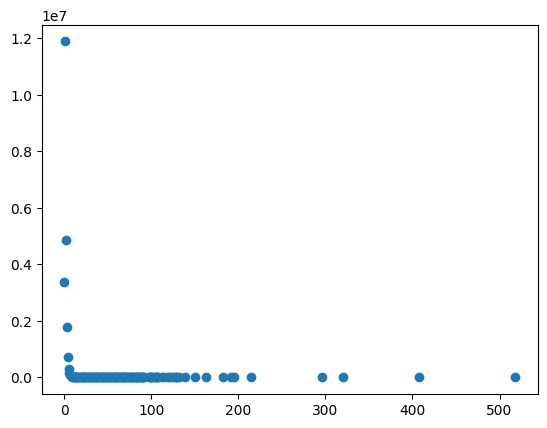

In [29]:
x = df['answer_count']
y = df['count']

plt.scatter(x,y)
plt.show()

This does not clearly demonstrate how many questions go unanswered.\
The difference between the number of questions having a few answers and the rest is too great.\
I will generalise the data more into just two columns, answered and unanswered questions.

In [30]:
unanswered = df.iloc[0].sum()
answered = df.iloc[1:].sum()
print(f'Unanswered: {unanswered}')
print(f'Answered: {answered["count"]}')

Unanswered: 3367908
Answered: 19905101


In [31]:
answered_unanswered = {'Unanswered': unanswered, 'Answered':answered['count']}

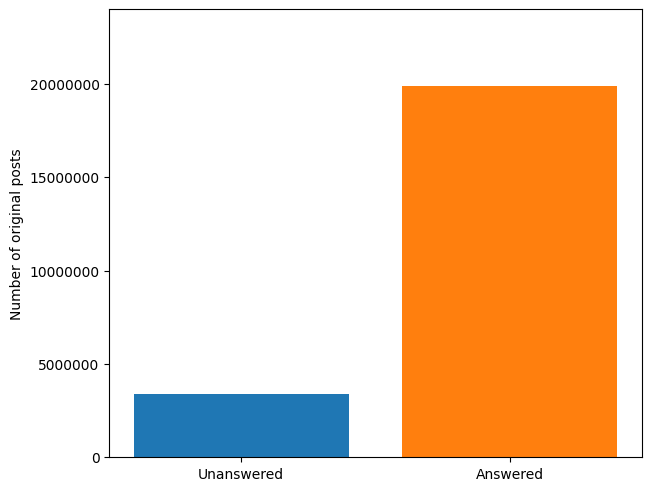

In [32]:
fig, ax = plt.subplots(layout='constrained')
ax.set_ylim(0, 24000000)
plt.ticklabel_format(style = 'plain')


for item, number in answered_unanswered.items():
    ax.bar(item, number)

plt.ylabel('Number of original posts')
plt.show()

In [33]:
total = unanswered + answered
unanswered_percent = (unanswered / total) * 100
unanswered_percent['count']

14.471304505575535

Only 14.47% of original posts across the whole dataset have gone completely unanswered.\
It would be useful to see how this has changed over time, and if more or less posts are being answered now.\
I do suspect that at the start, this will be lower, because there are less posts.\
But I also think that the percentage would be lower because it will be made up of a more devoted fan base.

In [34]:
query = "SELECT answer_count, creation_date::date FROM posts WHERE post_type_id = 1 AND creation_date > '2014-01-01' AND creation_date <= '2014-12-31'"
df = pd.read_sql(query, connection)
df['creation_date'] = pd.to_datetime(df['creation_date'])

In [35]:
for index, row in df.iterrows():
    if row['answer_count'] == 0:
        df.at[index, "unanswered"] = True
    else:
        df.at[index, "answered"] = True
df

/var/folders/05/y96nc2356cs8p4nnm3wghfvh0000gp/T/ipykernel_17975/861182144.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, "answered"] = True
/var/folders/05/y96nc2356cs8p4nnm3wghfvh0000gp/T/ipykernel_17975/861182144.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, "unanswered"] = True


,answer_count,creation_date,answered,unanswered
0,1,2014-01-01,True,NaN
1,1,2014-01-01,True,NaN
2,1,2014-01-01,True,NaN
3,1,2014-01-01,True,NaN
4,2,2014-01-01,True,NaN
...,...,...,...,...
2131392,3,2014-12-30,True,NaN
2131393,1,2014-12-30,True,NaN
2131394,2,2014-12-30,True,NaN
2131395,1,2014-12-30,True,NaN


I created two new columns, so that if the answer_count == 0, then True goes into the unanswered column, otherwise True goes into the answered column.\
This is simply to make it easier to count the Trues in each column based on date as below.


In [36]:
group_by_date_df = df.groupby('creation_date').count()
group_by_date_df['creation_date'] = group_by_date_df.index
group_by_date_df

,answer_count,answered,unanswered,creation_date
creation_date,,,,
2014-01-01,2954,2752,202,2014-01-01
2014-01-02,5762,5286,476,2014-01-02
2014-01-03,6115,5651,464,2014-01-03
2014-01-04,4006,3700,306,2014-01-04
2014-01-05,3722,3469,253,2014-01-05
...,...,...,...,...
2014-12-26,3492,3086,406,2014-12-26
2014-12-27,2848,2526,322,2014-12-27
2014-12-28,2922,2624,298,2014-12-28


Then I grouped by date, counting the number of trues in each column, with NaN's being disregarded.

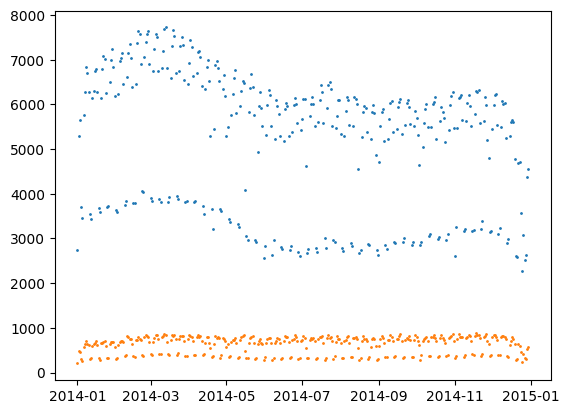

In [37]:
answered_x = group_by_date_df.index
answered_y = group_by_date_df['answered']

unanswered_x = group_by_date_df.index
unanswered_y = group_by_date_df['unanswered']

plt.scatter(answered_x, answered_y, s=1)
plt.scatter(unanswered_x, unanswered_y, s=1)
plt.show()

I will need to average out the values so there isn't such a large gap in the data due to the working day.


In [38]:
new_df = group_by_date_df.groupby(pd.Grouper(key='creation_date', freq='M')).mean().astype(int)
new_df.head(10)

,answer_count,answered,unanswered
creation_date,,,
2014-01-31,6135,5603,531
2014-02-28,6756,6124,631
2014-03-31,6741,6078,662
2014-04-30,6514,5859,654
2014-05-31,5720,5124,596
2014-06-30,5462,4850,611
2014-07-31,5759,5119,639
2014-08-31,5317,4724,592
2014-09-30,5584,4935,648


I decided to average them out by month, as by weekly, you can still get skewed data based on the drop in posts on the weekend, and might be too many points across many years.


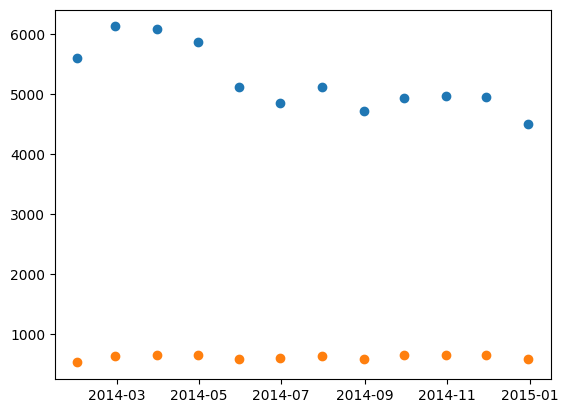

In [39]:
answered_x = new_df.index
answered_y = new_df['answered']

unanswered_x = new_df.index
unanswered_y = new_df['unanswered']

plt.scatter(answered_x, answered_y)
plt.scatter(unanswered_x, unanswered_y)
plt.show()

I think a bar chart might be better suited so that the difference is more defined.


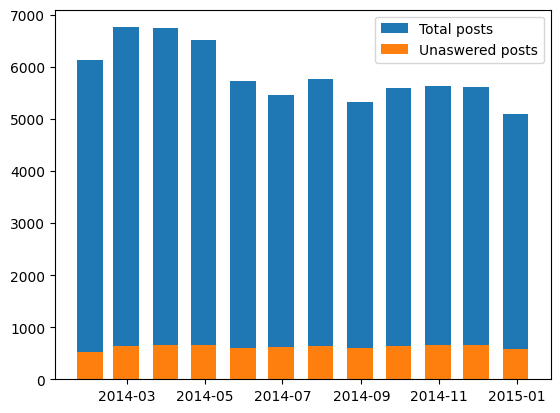

In [40]:
plt.bar(answered_x, new_df['answer_count'], width=20, label='Total posts')
plt.bar(unanswered_x, unanswered_y, width=20, label='Unaswered posts')
plt.legend()
plt.show()

For the year of 2014, I can now see the number of posts vs the number of posts going unanswered.\
I was originally putting the unanswered posts in blue, but would end up lower and thought I would try using a 'stacked bar graph' style instead.\
The next step is to try this for the entire dataset and see if I can see any trends over the years.\
\
First I needed to improve my query. I was drawing basic data out and then using pandas to modify it row by row, which was taking over 20 minutes.\
I paired with Alex and got a good query below to get the same logic happening all within the query. This improved the the two cells down to just 3 minutes.


In [41]:
query = "SELECT creation_date::date, answer_count, CASE WHEN answer_count = 0 THEN TRUE END AS unanswered, CASE WHEN answer_count > 0 THEN TRUE END AS answered FROM posts WHERE post_type_id = 1 GROUP BY creation_date, answer_count;"
df = pd.read_sql(query, connection)

In [42]:
df_copy = df.copy()
df_copy

,creation_date,answer_count,unanswered,answered
0,2008-07-31,14,None,True
1,2008-07-31,7,None,True
2,2008-07-31,71,None,True
3,2008-07-31,41,None,True
4,2008-08-01,27,None,True
...,...,...,...,...
23271727,2022-12-04,0,True,None
23271728,2022-12-04,0,True,None
23271729,2022-12-04,0,True,None
23271730,2022-12-04,0,True,None


I then started copying the data into a new variable so the original dataframe remains untouched.\
That way if I ruin the copied dataframe, I can just run the copy cell without having to run the query again.

In [43]:
df_copy['creation_date'] = pd.to_datetime(df_copy['creation_date'])
df_copy = df_copy.groupby('creation_date').count()
df_copy['creation_date'] = df_copy.index
new_df = df_copy.groupby(pd.Grouper(key='creation_date', freq='M')).mean().astype(int)

In [44]:
new_df

,answer_count,unanswered,answered
creation_date,,,
2008-07-31,4,0,4
2008-08-31,122,0,121
2008-09-30,471,0,471
2008-10-31,472,0,472
2008-11-30,426,0,425
...,...,...,...
2022-08-31,4551,1703,2847
2022-09-30,4380,1671,2708
2022-10-31,4367,1732,2635


Using a new query, I was able to very quickly get an average of all the unanswered vs answered original posts for the whole dataset.


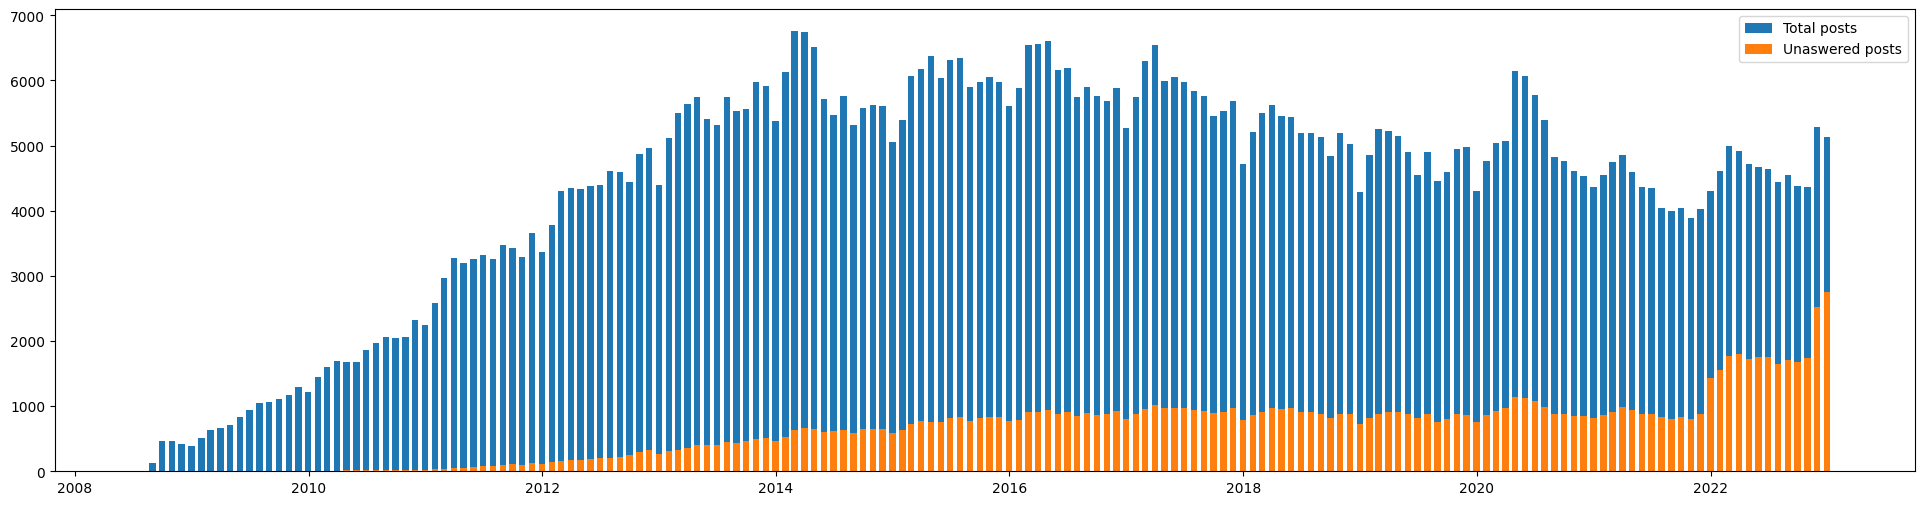

In [45]:
answered_x = new_df.index
answered_y = new_df['answered']

unanswered_x = new_df.index
unanswered_y = new_df['unanswered']


plt.figure(figsize=(24, 6))
plt.bar(answered_x, new_df['answer_count'], width=20, label='Total posts')
plt.bar(unanswered_x, unanswered_y, width=20, label='Unaswered posts')
plt.legend()
plt.show()

This shows a clear trend in the number of questions going unanswered.\
I would expect as the number of posts increased up to 2014, the number of unanswered to also increase.\
But after that, it still steadily increases, and from 2022 onwards, takes large jumps up.\
It could be something external to the dataset, and wider world, such as chat-gpt or other forum sites.\
\
I also want to find out the percentage of questions going unanswered.

In [46]:
for index, row in new_df.iterrows():
    unanswered_percent = (row['unanswered'] / row['answer_count']) * 100
    new_df.at[index, "percent_unanswered"] = unanswered_percent.round().astype(int)
new_df

,answer_count,unanswered,answered,percent_unanswered
creation_date,,,,
2008-07-31,4,0,4,0.0
2008-08-31,122,0,121,0.0
2008-09-30,471,0,471,0.0
2008-10-31,472,0,472,0.0
2008-11-30,426,0,425,0.0
...,...,...,...,...
2022-08-31,4551,1703,2847,37.0
2022-09-30,4380,1671,2708,38.0
2022-10-31,4367,1732,2635,40.0


After doing this, I could have made another column with an equation in the query to also get the percentage.

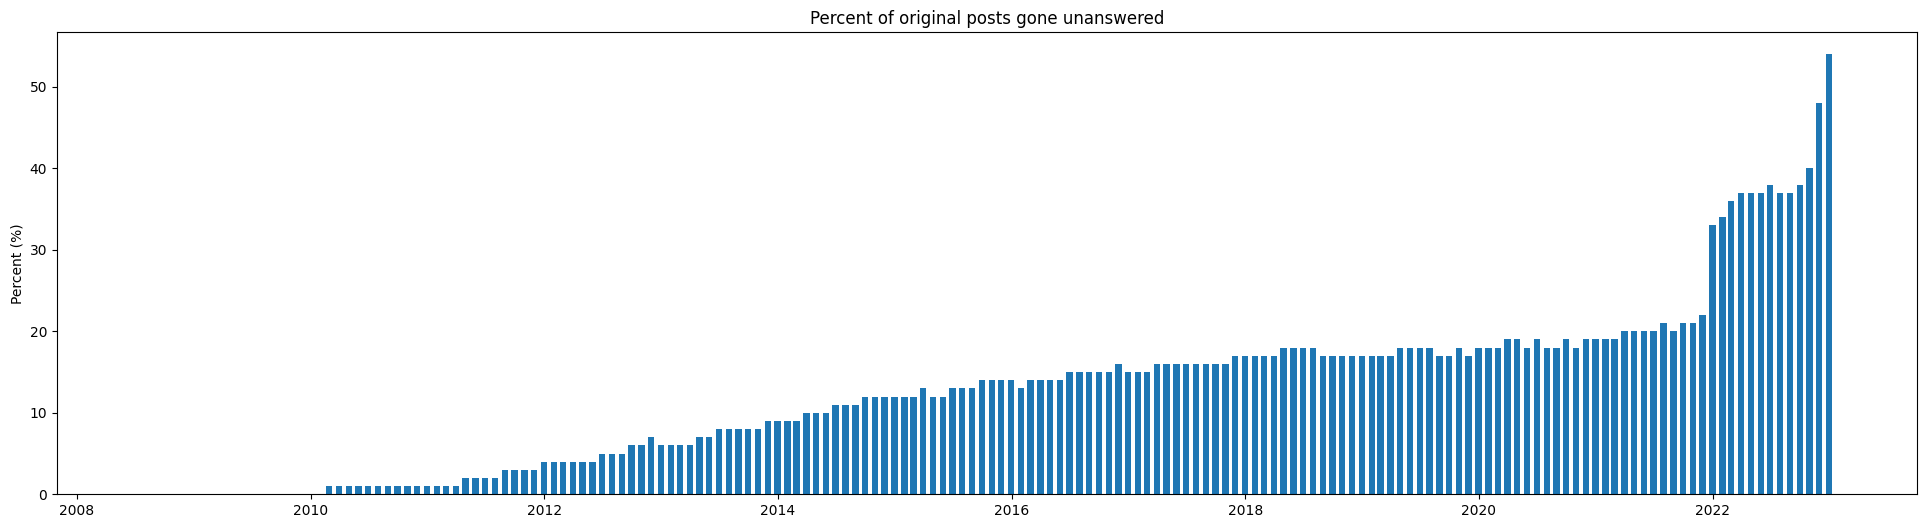

In [47]:
x = new_df.index
y = new_df['percent_unanswered']

plt.figure(figsize=(24, 6))
plt.bar(x, y, width=20)
plt.ylabel('Percent (%)')
plt.title('Percent of original posts gone unanswered')
plt.show()

In late 2022, over 50% of posts didn't have a single answer on them.\
I would now like to explore the unanswered posts as to why these posts are going unanswered.\
I will first go by day of the week, and see if posts on certain days of the week go more unanswered than others.


In [48]:
query = "SELECT creation_date::date, COUNT(*) FROM posts WHERE post_type_id = 1 AND answer_count = 0 GROUP BY creation_date"
df = pd.read_sql(query, connection)

In [49]:
df_copy = df.copy()
df_copy['creation_date'] = pd.to_datetime(df_copy['creation_date'], format='%Y%m%d')

df_copy['day'] = df_copy['creation_date'].dt.day_name()
series = df_copy['day'].value_counts()

In [50]:
series

day
Wednesday    591076
Thursday     583463
Tuesday      578255
Monday       538052
Friday       513167
Sunday       285306
Saturday     278504
Name: count, dtype: int64

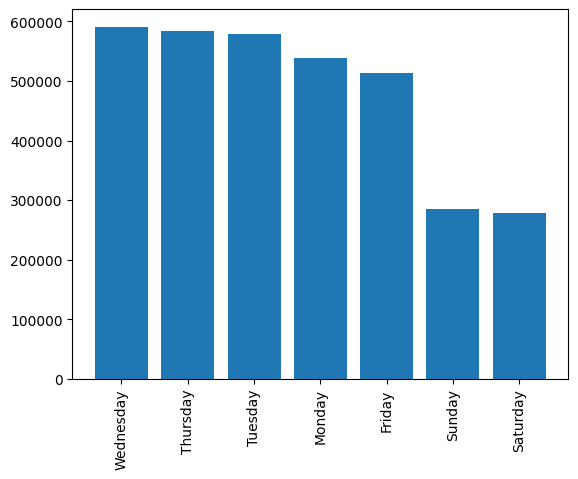

In [51]:
x = series.index[0:7]
y = series.iloc[0:7]

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

This doesn't tell me all that much, only that there are more questions in the middle of the week and far less on the weekend.\
Maybe I should take a look at tags in the questions asked.


In [52]:
query = "SELECT creation_date::date, tags FROM posts WHERE post_type_id = 1 AND answer_count = 0"
df = pd.read_sql(query, connection)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367908 entries, 0 to 3367907
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   creation_date  object
 1   tags           object
dtypes: object(2)
memory usage: 51.4+ MB


In [54]:
df.describe()

,creation_date,tags
count,3367908,3367908
unique,5093,1810630
top,2022-12-01,<android>
freq,3719,15569


In [55]:
counter = {}

tags_df = df['tags']
for tags in tags_df:
    list_of_tags = tags.strip('<').strip('>').split('><')
    for word in list_of_tags:
        if word not in counter:
            counter[word] = 0
        counter[word] += 1
sorted(counter.items(), key=lambda x:x[1], reverse=True)

[('javascript', 343574),
 ('python', 325337),
 ('java', 265462),
 ('android', 239852),
 ('c#', 205366),
 ('php', 185633),
 ('html', 130866),
 ('jquery', 107671),
 ('ios', 106399),
 ('c++', 99422),
 ('node.js', 91536),
 ('reactjs', 90381),
 ('css', 80130),
 ('r', 79232),
 ('mysql', 77767),
 ('python-3.x', 56590),
 ('swift', 54935),
 ('angular', 53217),
 ('sql', 50983),
 ('django', 50166),
 ('asp.net', 45245),
 ('json', 44430),
 ('excel', 41411),
 ('c', 39370),
 ('angularjs', 38885),
 ('.net', 38819),
 ('spring', 38218),
 ('typescript', 37369),
 ('sql-server', 35776),
 ('ruby-on-rails', 35335),
 ('wordpress', 34877),
 ('linux', 33521),
 ('mongodb', 33464),
 ('ajax', 32976),
 ('pandas', 32427),
 ('laravel', 32237),
 ('spring-boot', 31997),
 ('react-native', 31378),
 ('flutter', 31253),
 ('arrays', 30078),
 ('amazon-web-services', 29777),
 ('windows', 29641),
 ('firebase', 29033),
 ('docker', 28995),
 ('objective-c', 28548),
 ('vba', 27810),
 ('postgresql', 26449),
 ('asp.net-mvc', 26274),

Looking at the above list of results, javascript, python, java, android and c# are the top 5 most unanswered questions based on tags./

## Conclusion
I've not come to any real conclusion, only that there is a large number of posts more recently going entirely unanswered./
If I was to continue the project and looking at these data, I would do the following:
- Find relationships between frequency of tags in an unanswered post vs answered posts
- Maybe look at key words in the title and body, or the length of the title and body.
- Look at external events such as other websites and options launching such as sub-reddits on reddit, chat-gpt, or AI assistants like co-pilot.